## Data preprocessing

In [79]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [3]:
labels_:dict={"cardboard":0,"glass":2,"metal":3,"paper":1,"plastic":5,"trash":4}
SIZE:tuple=(224,224) # MobileNetV2 typically expects images of size 224x224 pixels

In [4]:
def load_data(path: str,size:tuple=(150,150)) -> tuple:
    images = []
    labels = []
    class_names = []
    
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            for img_name in tqdm(os.listdir(class_path), desc=f"Loading {class_name}"):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, size)  # Resize images to 150x150
                    images.append(img)
                    labels.append(labels_[class_name])
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

## load data

In [5]:
imgs_data,labels_data = load_data("/kaggle/input/garbage-classification/Garbage classification/Garbage classification",SIZE)

Loading plastic: 100%|██████████| 482/482 [00:03<00:00, 139.58it/s]


### Apply augmentation to the dataset

In [6]:
# Define the image data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,         # Randomly rotate images in the range 0-20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,    # Randomly shift images vertically by 20% of the height
    shear_range=0.2,           # Randomly shear images
    zoom_range=0.2,            # Randomly zoom into images
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in newly created pixels after rotation or shift
)

# Augment the dataset
augmented_images = []
augmented_labels = []

augmentation_count = int(len(imgs_data) * (1/3))

for img, label in zip(imgs_data, labels_data):
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0].astype('uint8'))
        augmented_labels.append(label)
        i += 1
        if i >= (augmentation_count / len(imgs_data)):
            break

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine the original and augmented data
final_imgs_data = np.concatenate((imgs_data, augmented_images), axis=0)
final_labels_data = np.concatenate((labels_data, augmented_labels), axis=0)

In [7]:
print("Size before augmentation : ",imgs_data.shape[0])
print("Size After augmentation : ",final_imgs_data.shape[0])

Size before augmentation :  2527
Size After augmentation :  5054


### Display images

In [8]:
def show_random_images(images: np.ndarray, labels: np.ndarray, num_samples: int, mode: str = 'BGR2RGB'):
    if num_samples > len(images):
        raise ValueError("Number of samples requested exceeds available samples.")
    
    # Randomly select indices
    random_indices = random.sample(range(len(images)), num_samples)
    
    class_names={j:i for i,j in labels_.items()}
    
    selected_images = images[random_indices]
    selected_labels = [class_names[labels[index]].capitalize() for index in random_indices]

    # Define the number of rows and columns for displaying images
    num_cols = 3
    num_rows = (num_samples + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))

    for i, (img, label) in enumerate(zip(selected_images, selected_labels)):
        plt.subplot(num_rows, num_cols, i + 1)
        if isinstance(mode,str) and not mode is None:
            mode=mode.upper()
        if mode == 'GRAY':
            img_display = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            plt.imshow(img_display, cmap='gray')
        elif mode == 'BGR2RGB':
            img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img_display)
        elif mode == 'RGB':
            plt.imshow(img)
        else:
            raise ValueError(f"Unsupported mode: {mode}")
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [36]:
def display_image(images: np.ndarray, labels: np.ndarray, index: int, mode: str = 'RGB'):
    if index >= len(images):
        raise ValueError("Index is out of range for images array.")
    
    # Mapping of class indices to class names (assuming labels are numeric)
    class_names={j:i for i,j in labels_.items()}  # Replace with your actual class names or logic
    
    img = images[index]
    label = class_names[labels[index]]

    plt.figure(figsize=(5, 5))
    
    if isinstance(mode, str) and mode.upper() == 'GRAY':
        img_display = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        plt.imshow(img_display, cmap='gray')
    elif isinstance(mode, str) and mode.upper() == 'BGR2RGB':
        img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_display)
    elif isinstance(mode, str) and mode.upper() == 'RGB':
        plt.imshow(img)
    else:
        raise ValueError(f"Unsupported mode: {mode}")
    
    plt.title(label.capitalize())
    plt.axis('off')
    plt.show()

### Split the data

In [9]:
# Split data into training+validation (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(final_imgs_data, final_labels_data, test_size=0.2, random_state=42)

In [10]:
# Convert labels to one-hot encoding
num_classes = len(np.unique(labels_data))
num_classes

6

### Display the train data

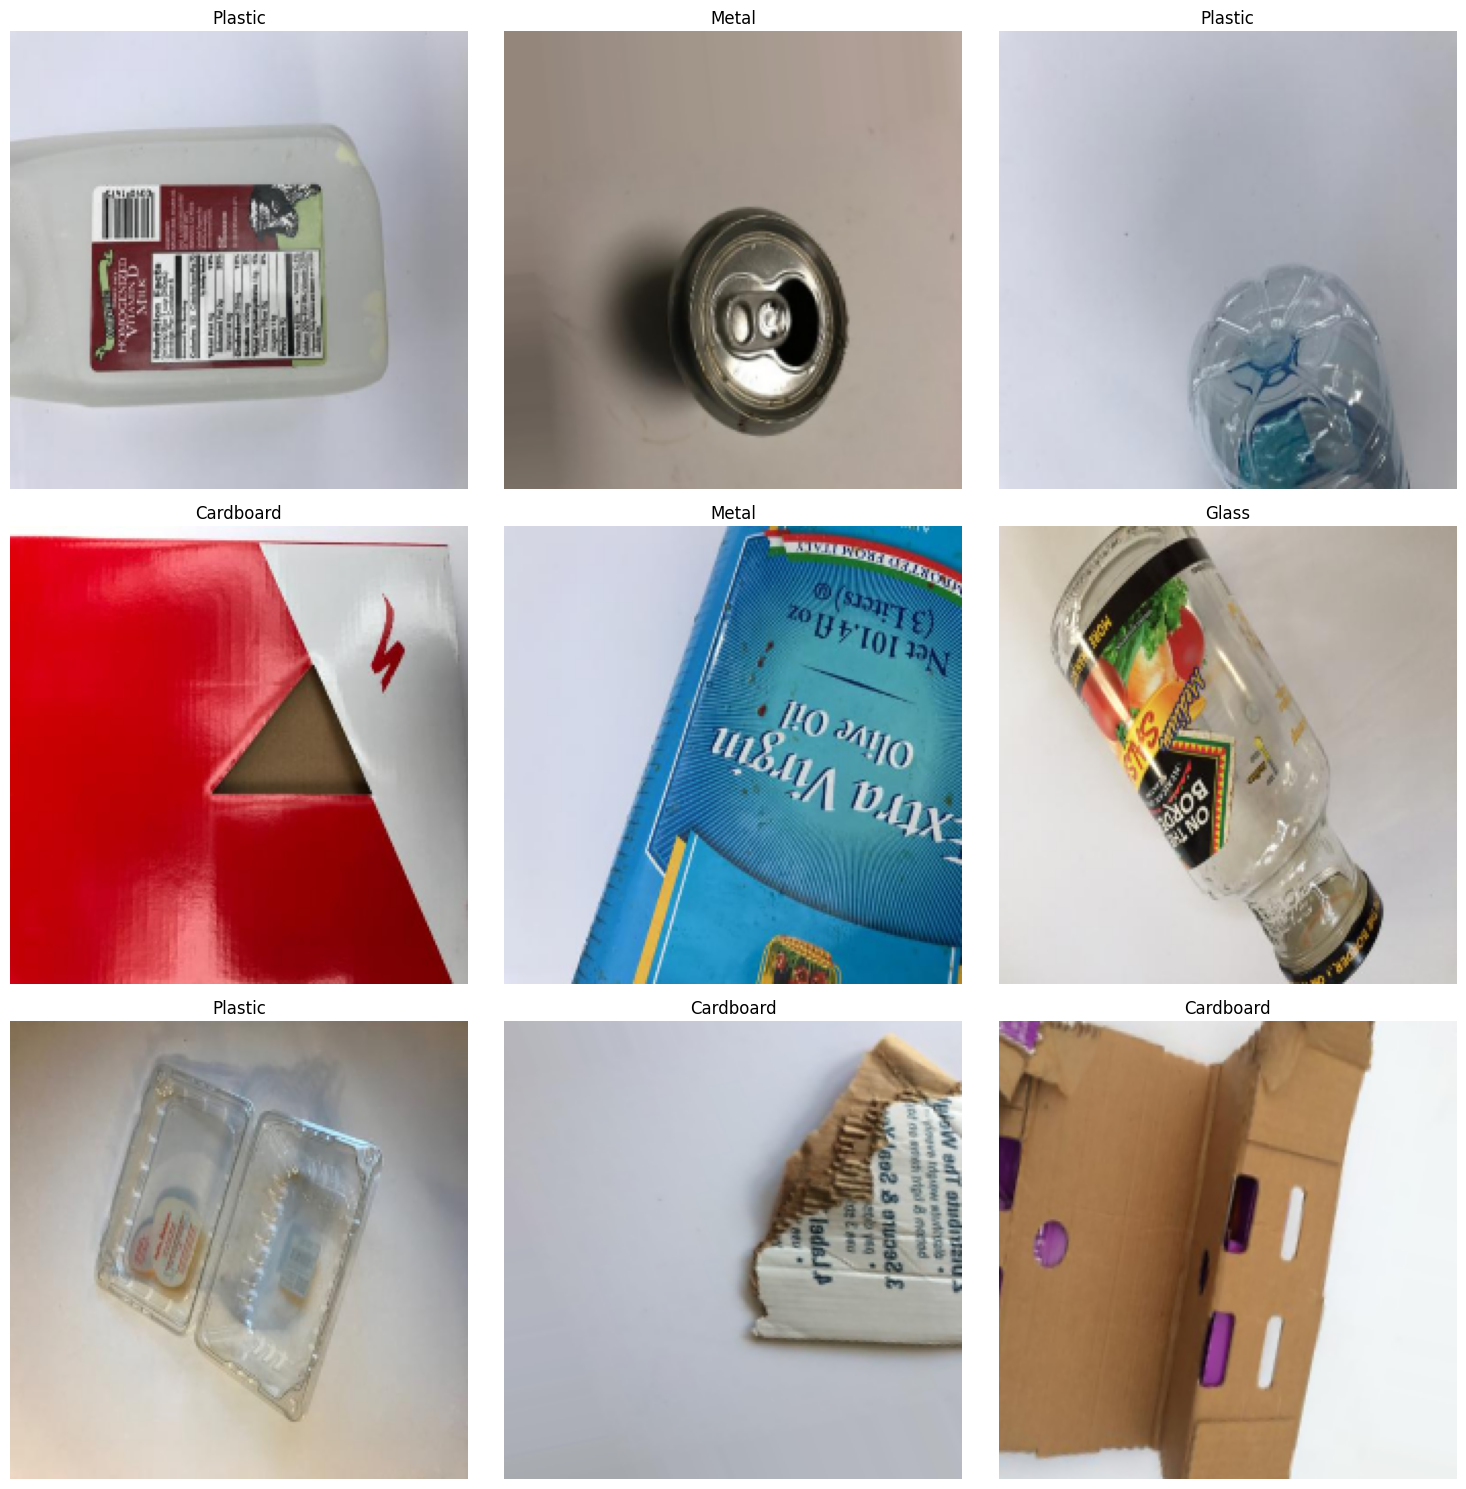

In [11]:
show_random_images(X_train, y_train,9)

### Display the test data

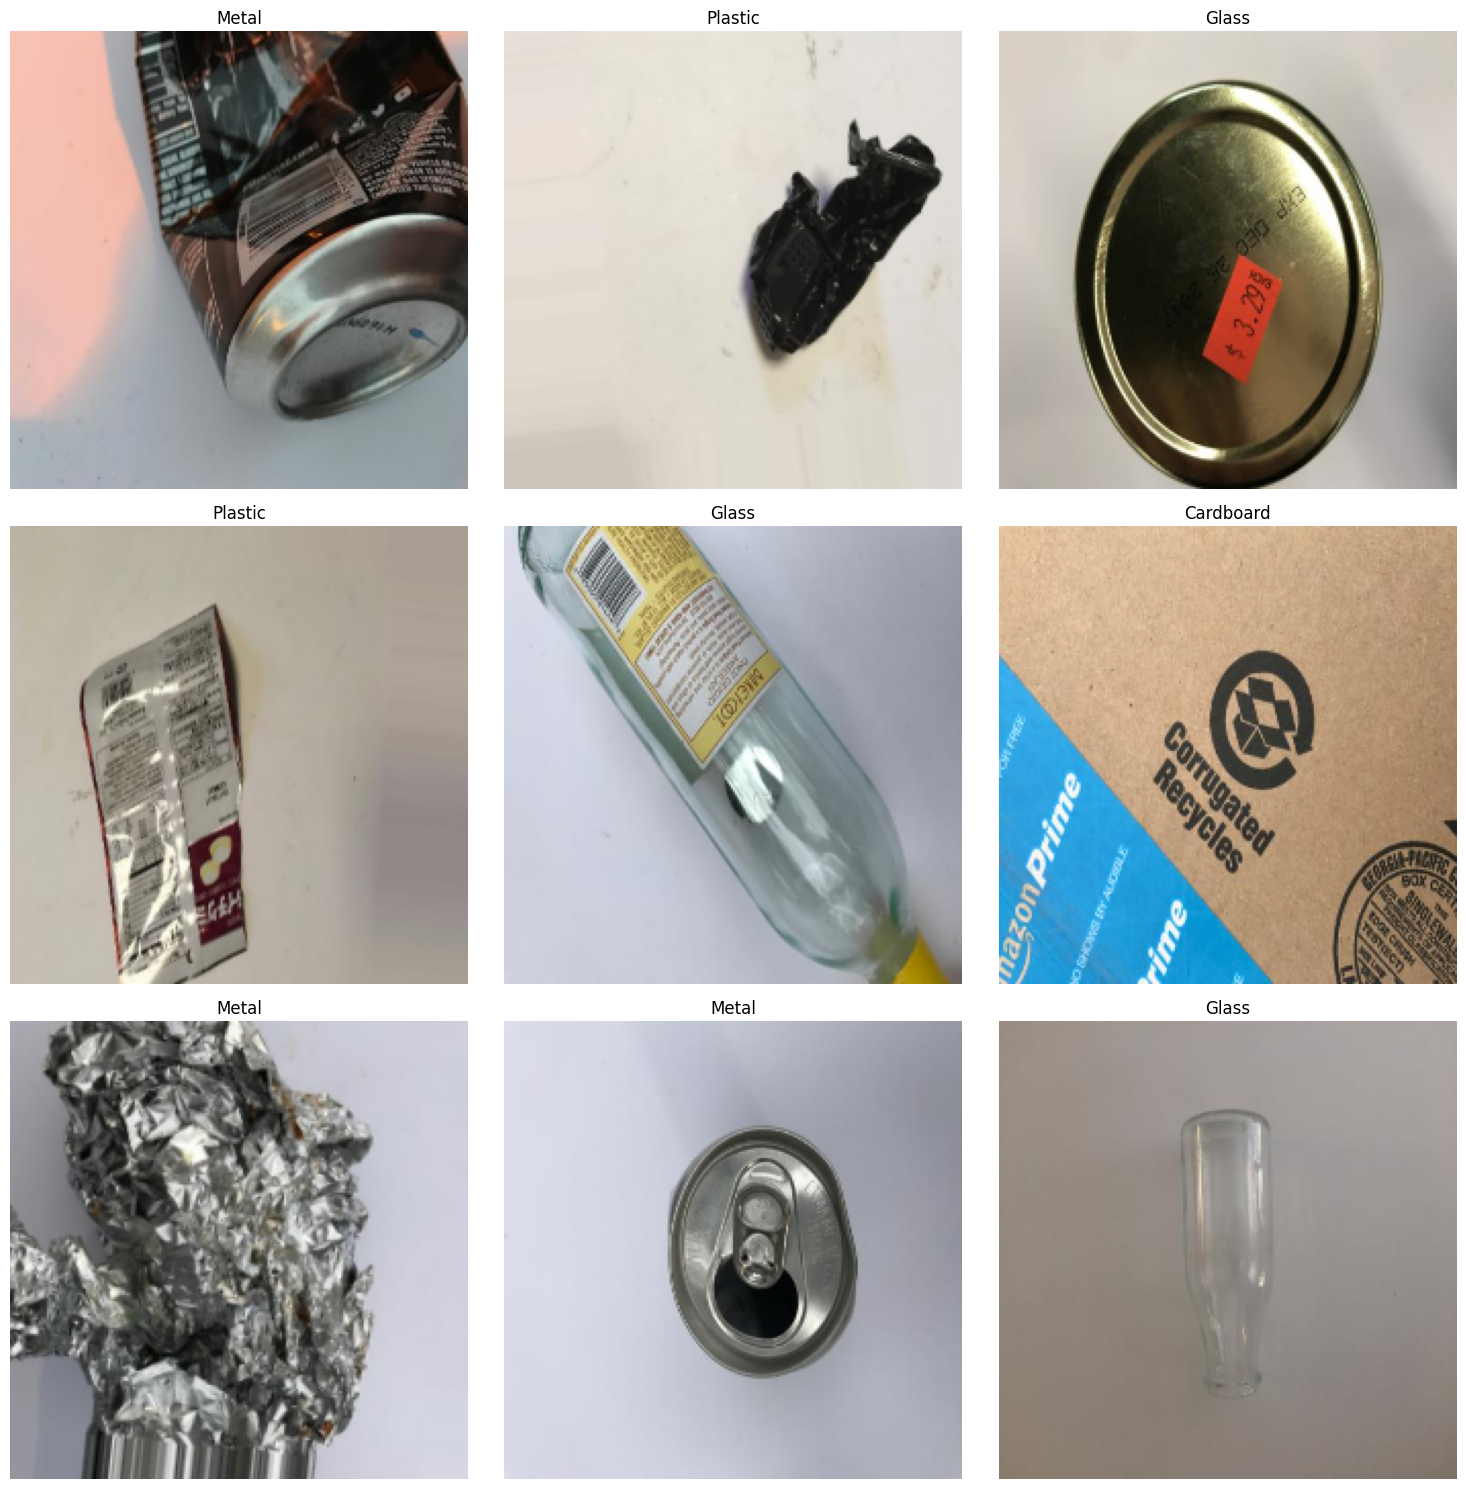

In [12]:
show_random_images(X_test, y_test,9)

### Transfer Laerning with MobileNetV2

### Normalize Data

In [13]:
# Normalize your image data
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)

### Define the MobileNetV2 model

In [14]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Freeze the base model

In [15]:
base_model.trainable = False

### Create a new model on top

In [67]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),    
    Dense(num_classes, activation='softmax')  # assuming classification task
])

### Compile the model

In [68]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

### Define early stopping callback


In [69]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

### Train the model

In [70]:
# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - loss: 1.3124 - sparse_categorical_accuracy: 0.5078 - val_loss: 0.7284 - val_sparse_categorical_accuracy: 0.7330
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.6002 - sparse_categorical_accuracy: 0.7880 - val_loss: 0.6097 - val_sparse_categorical_accuracy: 0.7738
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.4559 - sparse_categorical_accuracy: 0.8521 - val_loss: 0.5588 - val_sparse_categorical_accuracy: 0.7960
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.3732 - sparse_categorical_accuracy: 0.8863 - val_loss: 0.5320 - val_sparse_categorical_accuracy: 0.7985
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.3068 - sparse_categorical_accuracy: 0.9065 - val_loss: 0.4986 - val_sparse_categorical_accuracy: 0.8146
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.2725 - sparse_categorical_accuracy: 0.9230 - val_loss: 0.4744 - val_sparse_categorical_accuracy: 0.8

### Evaluate the model

In [71]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.3221 - sparse_categorical_accuracy: 0.8872
Test accuracy: 0.8921859264373779


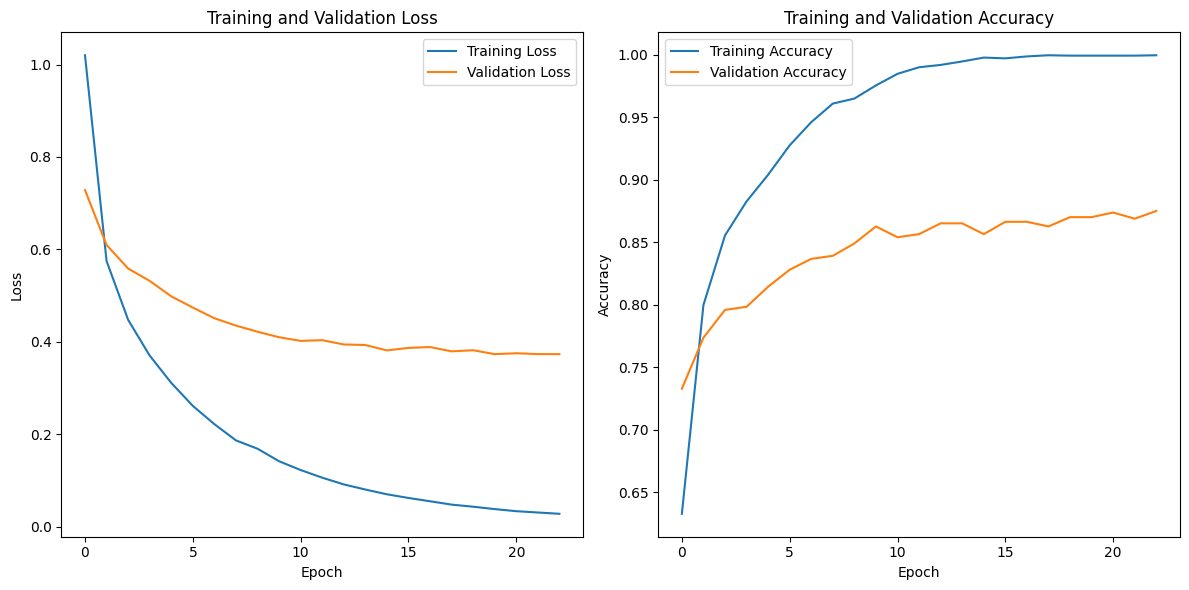

In [72]:
# Extracting history from training
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class: metal,	 Real class: metal


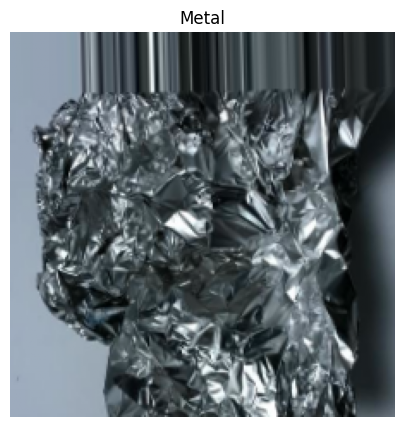

In [78]:
# Make predictions
index_test = 120
# Assuming X_train[0] is the first image in your training data
image_to_predict = np.expand_dims(X_test[index_test], axis=0)  # Add batch dimension if necessary

# Make predictions
predictions = model.predict(image_to_predict)
predicted_class = np.argmax(predictions[0])
classes = {value:key for key,value in labels_.items()}
# Print predicted class
print(f"Predicted class: {classes[predicted_class]},\t Real class: {classes[y_test[index_test]]}")
display_image(X_test,y_test,index_test)

In [80]:
# Assuming 'model' is your trained Keras model
model.save('garbage_classifier.h5')